In [14]:
import numpy as np
import pandas as pd
import sys
import collections, functools, operator

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
import pickle
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.manifold import TSNE

In [58]:
df_prices=pd.read_excel("intraday_etfs.xlsx",index_col=0)
df_prices

,AGQ,CGW,DBA,DBB,DBC,DBE,DBO,DBP,DBS,DDG,...,UNG,USL,USO,USV,VDE,XES,XLE,XME,XOP,ZSL
Time,,,,,,,,,,,,,,,,,,,,,
2009-01-02 14:35:00,61.580,12.098039,25.755,12.150,21.066,19.759825,19.576,29.153,20.146404,68.079093,...,747.072,30.69,33.910,15.643,55.039,15.723,38.581,24.582,27.365,1751.400
2009-01-02 14:40:00,61.880,12.098039,25.764,13.097,20.998,19.759825,19.536,29.222,19.792000,68.079093,...,744.608,30.54,33.740,15.643,55.362,15.882,38.749,25.107,27.529,1818.000
2009-01-02 14:45:00,62.000,12.231000,25.821,13.097,20.998,19.759825,19.536,29.222,19.792000,68.079093,...,744.000,30.54,33.700,15.643,55.273,15.896,38.733,25.028,27.593,1823.000
2009-01-02 14:50:00,62.780,12.119000,25.794,12.141,20.988,20.163000,19.536,29.222,19.831000,68.079093,...,744.832,30.54,33.530,15.643,55.321,15.987,38.781,25.081,27.648,1823.000
2009-01-02 14:55:00,62.000,12.119000,25.745,12.268,20.998,20.172000,19.517,29.222,19.831000,68.079093,...,747.200,30.54,33.640,15.643,55.039,15.796,38.573,24.932,27.383,1823.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 20:40:00,26.430,31.020000,16.935,15.370,14.504,12.450000,8.480,36.350,22.862000,27.595000,...,24.690,17.97,9.690,18.312,76.960,8.980,57.210,26.130,26.510,37.015
2018-12-31 20:45:00,26.444,31.111000,16.930,15.370,14.510,12.450000,8.480,36.350,22.982000,27.595000,...,24.690,17.98,9.690,18.312,77.120,9.010,57.330,26.180,26.560,37.020
2018-12-31 20:50:00,26.447,31.080000,16.930,15.380,14.500,12.450000,8.474,36.350,22.982000,27.595000,...,24.690,17.97,9.674,18.312,76.846,8.960,57.130,26.140,26.445,37.020


**Data Preprocessing**

In [59]:
def remove_tickers_with_nan(df, threshold):
    """
    Removes columns with more than threshold null values
    """
    null_values = df.isnull().sum()
    null_values = null_values[null_values > 0]

    to_remove = list(null_values[null_values > threshold].index)
    df = df.drop(columns=to_remove)

    return df

In [62]:
df_prices=remove_tickers_with_nan(df_prices,0)

In [63]:
df_prices_interpolate = df_prices.interpolate(method="linear")

In [64]:
df_returns = df_prices_interpolate.pct_change().iloc[1:]
df_returns

,AGQ,CGW,DBA,DBB,DBC,DBE,DBO,DBP,DBS,DDG,...,UNG,USL,USO,USV,VDE,XES,XLE,XME,XOP,ZSL
Time,,,,,,,,,,,,,,,,,,,,,
2009-01-02 14:40:00,0.004872,0.000000,0.000349,0.077942,-0.003228,0.000000,-0.002043,0.002367,-0.017591,0.0,...,-0.003298,-0.004888,-0.005013,0.0,0.005869,0.010113,0.004354,0.021357,0.005993,0.038027
2009-01-02 14:45:00,0.001939,0.010990,0.002212,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,-0.000817,0.000000,-0.001186,0.0,-0.001608,0.000882,-0.000413,-0.003147,0.002325,0.002750
2009-01-02 14:50:00,0.012581,-0.009157,-0.001046,-0.072994,-0.000476,0.020404,0.000000,0.000000,0.001970,0.0,...,0.001118,0.000000,-0.005045,0.0,0.000868,0.005725,0.001239,0.002118,0.001993,0.000000
2009-01-02 14:55:00,-0.012424,0.000000,-0.001900,0.010460,0.000476,0.000446,-0.000973,0.000000,0.000000,0.0,...,0.003179,0.000000,0.003281,0.0,-0.005098,-0.011947,-0.005363,-0.005941,-0.009585,0.000000
2009-01-02 15:00:00,0.000000,0.000000,0.000738,0.000000,0.001429,0.000000,-0.002511,0.000000,0.001462,0.0,...,-0.002398,0.000000,0.001219,0.0,0.004106,0.008040,0.003941,0.005174,0.004346,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 20:40:00,0.000379,0.000000,0.000295,0.000000,0.000276,0.000000,0.000000,0.000000,0.000000,0.0,...,0.001217,0.000000,0.000723,0.0,-0.000909,-0.001112,-0.000873,0.001533,-0.000942,0.000000
2018-12-31 20:45:00,0.000530,0.002934,-0.000295,0.000000,0.000414,0.000000,0.000000,0.000000,0.005249,0.0,...,0.000000,0.000556,0.000000,0.0,0.002079,0.003341,0.002098,0.001914,0.001886,0.000135
2018-12-31 20:50:00,0.000113,-0.000996,0.000000,0.000651,-0.000689,0.000000,-0.000708,0.000000,0.000000,0.0,...,0.000000,-0.000556,-0.001651,0.0,-0.003553,-0.005549,-0.003489,-0.001528,-0.004330,0.000000


In [65]:
print(df_returns.columns)

Index(['AGQ', 'CGW', 'DBA', 'DBB', 'DBC', 'DBE', 'DBO', 'DBP', 'DBS', 'DDG',
       'DGL', 'DGP', 'DGZ', 'DIG', 'DJP', 'DTO', 'DUG', 'DZZ', 'ERX', 'ERY',
       'FCG', 'FIW', 'FUD', 'FUE', 'FXN', 'GCC', 'GDX', 'GLD', 'GLL', 'GRU',
       'GSC', 'GSG', 'GSP', 'IAU', 'IEO', 'IEZ', 'IXC', 'IYE', 'KOL', 'LD',
       'NIB', 'NLR', 'PHO', 'PIO', 'PXE', 'PXI', 'PXJ', 'RJA', 'RJI', 'RJN',
       'RJZ', 'RYE', 'SCO', 'SLV', 'UAG', 'UBG', 'UCI', 'UCO', 'UGA', 'UGL',
       'UNG', 'USL', 'USO', 'USV', 'VDE', 'XES', 'XLE', 'XME', 'XOP', 'ZSL'],
      dtype='object')


In [66]:
df_returns.isnull().values.any()

False

**Apply PCA**

In [71]:
pca = PCA(n_components=5, svd_solver='auto', random_state=0)
pca.fit(df_returns)
explained_variance = pca.explained_variance_

# standardize
X = preprocessing.StandardScaler().fit_transform(pca.components_.T)

print(explained_variance)
print(X.shape) # 70 tickers with 5 features each, (70,5)

[5.18525307e-01 1.68851597e-04 5.70581831e-05 5.24895876e-05
 2.96361148e-05]
(70, 5)


**Clustering**

In [73]:
def apply_DBSCAN(eps, min_samples, X, df_returns):
    """
    This function applies a DBSCAN clustering algo
    :param eps: min distance for a sample to be within the cluster
    :param min_samples: min_samples to consider a cluster
    :param X: data
    :return: clustered_series_all: series with all tickers and labels
    :return: clustered_series: series with tickers belonging to a cluster
    :return: counts: counts of each cluster
    :return: clf object
    """
    clf = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    #print(clf)

    clf.fit(X)
    labels = clf.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print("Clusters discovered: %d" % n_clusters_)

    clustered_series_all = pd.Series(index=df_returns.columns, data=labels.flatten())
    clustered_series = clustered_series_all[clustered_series_all != -1]

    counts = clustered_series.value_counts()
    print("Pairs to evaluate: %d" % (counts * (counts - 1) / 2).sum())

    return clustered_series_all, clustered_series, counts, clf

def apply_OPTICS(X, df_returns, min_samples, max_eps=2, xi=0.05, cluster_method='xi'):
    """
    :param X:
    :param df_returns:
    :param min_samples:
    :param max_eps:
    :param xi:
    :param eps:
    :return:
    """
    clf = OPTICS(min_samples=min_samples, max_eps=max_eps, xi=xi, metric='euclidean', cluster_method=cluster_method)
    print(clf)

    clf.fit(X)
    labels = clf.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    print("Clusters discovered: %d" % n_clusters_)

    clustered_series_all = pd.Series(index=df_returns.columns, data=labels.flatten())
    clustered_series = clustered_series_all[clustered_series_all != -1]

    counts = clustered_series.value_counts()
    print("Pairs to evaluate: %d" % (counts * (counts - 1) / 2).sum())

    return clustered_series_all, clustered_series, counts, clf

def cluster_size(counts):
    plt.figure()
    plt.barh(counts.index+1, counts.values)
    #plt.title('Cluster Member Counts')
    plt.yticks(np.arange(1, len(counts)+1, 1))
    plt.xlabel('ETFs within cluster', size=12)
    plt.ylabel('Cluster Id', size=12);

In [74]:
clustered_series_all, clustered_series, counts, clf = apply_OPTICS(X, df_returns, min_samples=3,cluster_method='xi')

OPTICS(max_eps=2, metric='euclidean', min_samples=3)
Clusters discovered: 6
Pairs to evaluate: 136


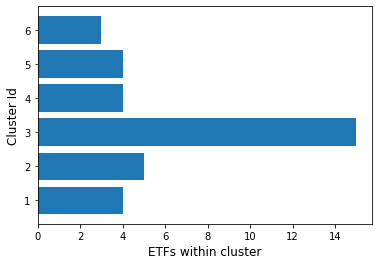

In [75]:
cluster_size(counts)

In [76]:
print(counts)
print('Average cluster size: ', np.mean(counts))

2    15
1     5
4     4
3     4
0     4
5     3
dtype: int64
Average cluster size:  5.833333333333333


In [77]:
def plot_TSNE(X, clf, clustered_series_all):
    """
    This function makes use of t-sne to visualize clusters in 2d.
    """
    
    X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X)
    
    # visualization
    fig = plt.figure(1, facecolor='white', figsize=(15,15), frameon=True, edgecolor='black')
    plt.clf()
    
    # axis in the middle
    ax = fig.add_subplot(1, 1, 1, alpha=0.9)
    # Move left y-axis and bottim x-axis to centre, passing through (0,0)
    ax.spines['left'].set_position('center')
    ax.spines['left'].set_alpha(0.3)
    ax.spines['bottom'].set_position('center')
    ax.spines['bottom'].set_alpha(0.3)
    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params(which='major', labelsize=18)
    #plt.axis('off')

    # etfs in cluster
    labels = clf.labels_
    x = X_tsne[(labels!=-1), 0]
    y = X_tsne[(labels!=-1), 1]
    tickers = list(clustered_series_all[clustered_series_all != -1].index)
    plt.scatter(
        x,
        y,
        s=300,
        alpha=0.75,
        c=labels[labels!=-1],
        cmap=cm.Paired
    )
    for i, ticker in enumerate(tickers):
        plt.annotate(ticker, (x[i]-20, y[i]+12), size=15)

    # remaining etfs, not clustered
    x = X_tsne[(clustered_series_all==-1).values, 0]
    y = X_tsne[(clustered_series_all==-1).values, 1]
    tickers = list(clustered_series_all[clustered_series_all == -1].index)

    # WARNING: elimintate outliers
    #outliers = ['DTO','SCO']
    outliers = ['DZZ', 'XME']
    to_remove_x = [x[clustered_series_all[clustered_series_all==-1].index.get_loc(outliers[0])],
                   x[clustered_series_all[clustered_series_all==-1].index.get_loc(outliers[1])]]
    to_remove_y = [y[clustered_series_all[clustered_series_all==-1].index.get_loc(outliers[0])],
                   y[clustered_series_all[clustered_series_all==-1].index.get_loc(outliers[1])]]
    x = np.array([i for i in x if i not in to_remove_x])
    y= np.array([i for i in y if i not in to_remove_y])

    plt.scatter(
        x,
        y,
        s=150,
        alpha=0.20,
        c='black'
    )
    #for i, ticker in enumerate(tickers):
    #    plt.annotate(ticker, (x[i]+20, y[i]+20))#, arrowprops={'arrowstyle':'simple'})
        
    #plt.title('OPTICS clusters visualized with t-SNE', size=16);
    plt.xlabel('t-SNE Dim. 1', position=(0.92,0), size=20)
    plt.ylabel('t-SNE Dim. 2', position=(0,0.92), size=20)
    ax.set_xticks(range(-300, 301, 600))
    ax.set_yticks(range(-300, 301, 600))
    #plt.savefig('DBSCAN_2014_2018_eps0_15.png', bbox_inches='tight', pad_inches=0.01)
    plt.savefig('OPTICS_2013_2017.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()
    # include connections - see quontopian

D:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


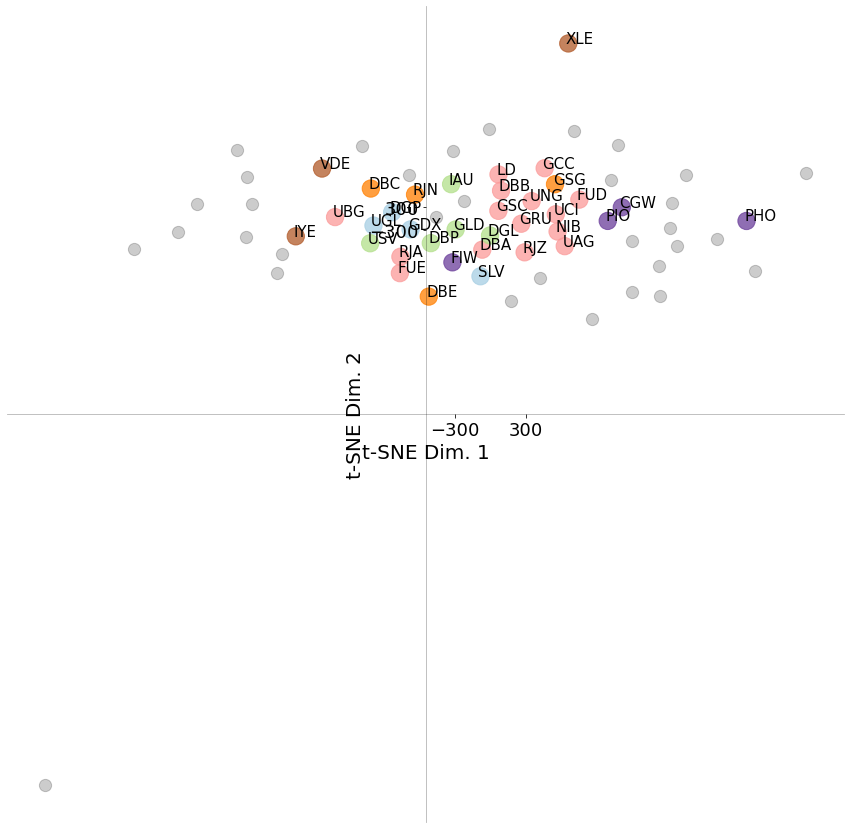

In [78]:
plot_TSNE(X,clf, clustered_series_all)

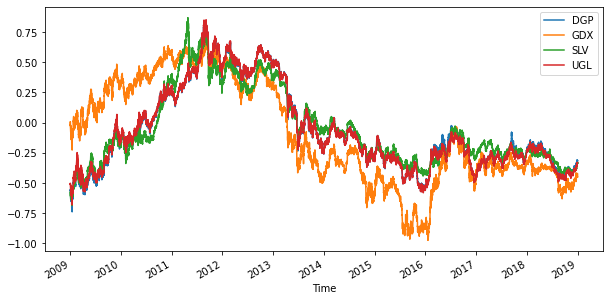

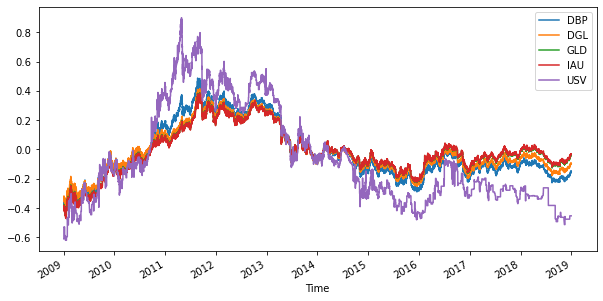

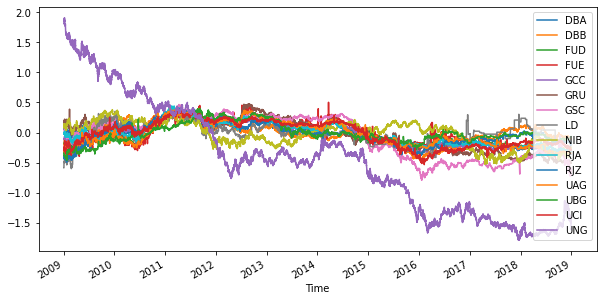

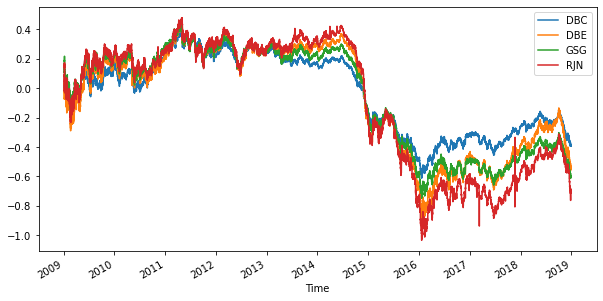

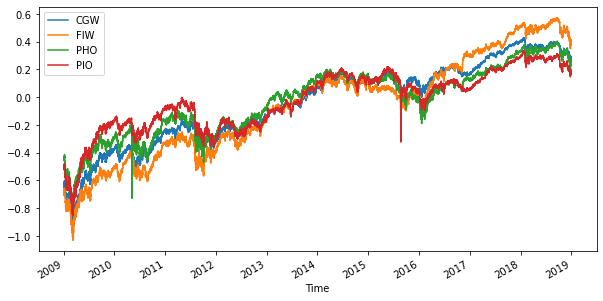

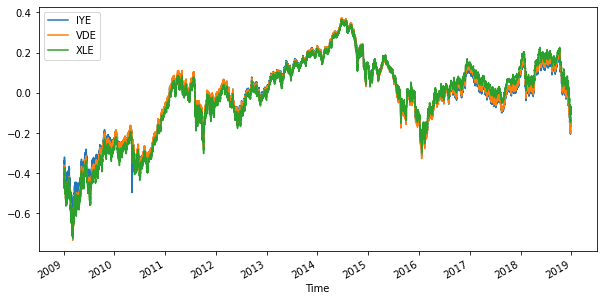

In [80]:
for clust in range(len(counts)):
    symbols = list(clustered_series[clustered_series==clust].index)
    means = np.log(df_prices[symbols].mean())
    series = np.log(df_prices[symbols]).sub(means)
    series.plot(figsize=(10,5))#title='ETFs Time Series for Cluster %d' % (clust+1))
    #plt.ylabel('Normalized log prices', size=12)
    #plt.xlabel('Date', size=12)
    plt.savefig('cluster_{}.png'.format(str(clust+1)), bbox_inches='tight', pad_inches=0.1)

In [81]:
def zscore(series):
        """
        Returns the nromalized time series assuming a normal distribution
        """
        return (series-series.mean())/np.std(series)

def calculate_half_life(z_array):
    """
    This function calculates the half life parameter of a
    mean reversion series
    """
    z_lag = np.roll(z_array, 1)
    z_lag[0] = 0
    z_ret = z_array - z_lag
    z_ret[0] = 0

    # adds intercept terms to X variable for regression
    z_lag2 = sm.add_constant(z_lag)

    model = sm.OLS(z_ret[1:], z_lag2[1:])
    res = model.fit()

    halflife = -np.log(2) / res.params[1]

    return halflife

def hurst(ts):
    """
    Returns the Hurst Exponent of the time series vector ts.
    Series vector ts should be a price series.
    Source: https://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing"""
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    # Here it calculates the variances, but why it uses
    # standard deviation and then make a root of it?
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0] * 2.0

def variance_ratio(ts, lag=2):
    """
    Returns the variance ratio test result
    Source: https://gist.github.com/jcorrius/56b4983ca059e69f2d2df38a3a05e225#file-variance_ratio-py
    """
    # make sure we are working with an array, convert if necessary
    ts = np.asarray(ts)

    # Apply the formula to calculate the test
    n = len(ts)
    mu = sum(ts[1:n] - ts[:n - 1]) / n
    m = (n - lag + 1) * (1 - lag / n)
    b = sum(np.square(ts[1:n] - ts[:n - 1] - mu)) / (n - 1)
    t = sum(np.square(ts[lag:n] - ts[:n - lag] - lag * mu)) / m
    return t / (lag * b)

def zero_crossings( x):
    """
    Function that counts the number of zero crossings of a given signal
    :param x: the signal to be analyzed
    """
    x = x - x.mean()
    zero_crossings = sum(1 for i, _ in enumerate(x) if (i + 1 < len(x)) if ((x[i] * x[i + 1] < 0) or (x[i] == 0)))

    return zero_crossings


In [96]:
def check_for_stationarity(X,subsample=0):
    """
    H_0 in adfuller is unit root exists (non-stationary).
    We must observe significant p-value to convince ourselves that the series is stationary.
    :param X: time series
    :param subsample: boolean indicating whether to subsample series
    :return: adf results
    """
    if subsample != 0:
        frequency = round(len(X)/subsample)
        subsampled_X = X[0::frequency]
        result = adfuller(subsampled_X)
    else:
        result = adfuller(X)
    # result contains:
    # 0: t-statistic
    # 1: p-value
    # others: please see https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

    return {'t_statistic': result[0], 'p_value': result[1], 'critical_values': result[4]}

In [97]:
 def check_properties(price_series,  p_value_threshold, min_half_life=78, max_half_life=20000,
                         min_zero_crossings=0, hurst_threshold=0.5, subsample=0):
        """
        Gets two time series as inputs and provides information concerning cointegration stasttics
        Y - b*X : Y is dependent, X is independent
        """

        # for some reason is not giving right results
        # t_statistic, p_value, crit_value = coint(X,Y, method='aeg')

        # perform test manually in both directions
        X = price_series[0]
        Y = price_series[1]
        pairs = [(X, Y), (Y, X)]
        pair_stats = [0] * 2
        criteria_not_verified = 'cointegration'

        # first of all, must verify price series S1 and S2 are I(1)
        stats_Y = check_for_stationarity(np.asarray(Y), subsample=subsample)
        if stats_Y['p_value'] > 0.10:
            stats_X = check_for_stationarity(np.asarray(X), subsample=subsample)
            if stats_X['p_value'] > 0.10:
                # conditions to test cointegration verified

                for i, pair in enumerate(pairs):
                    S1 = np.asarray(pair[0])
                    S2 = np.asarray(pair[1])
                    S1_c = sm.add_constant(S1)

                    # Y = bX + c
                    # ols: (Y, X)
                    results = sm.OLS(S2, S1_c).fit()
                    b = results.params[1]

                    if b > 0:
                        spread = pair[1] - b * pair[0] # as Pandas Series
                        spread_array = np.asarray(spread) # as array for faster computations

                        stats = check_for_stationarity(spread_array, subsample=subsample)
                        if stats['p_value'] < p_value_threshold:  # verifies required pvalue
                            criteria_not_verified = 'hurst_exponent'

                            hurst_exponent = hurst(spread_array)
                            if hurst_exponent < hurst_threshold:
                                criteria_not_verified = 'half_life'

                                hl = calculate_half_life(spread_array)
                                if (hl >= min_half_life) and (hl < max_half_life):
                                    criteria_not_verified = 'mean_cross'

                                    zero_cross = zero_crossings(spread_array)
                                    if zero_cross >= min_zero_crossings:
                                        criteria_not_verified = 'None'

                                        pair_stats[i] = {'t_statistic': stats['t_statistic'],
                                                          'critical_val': stats['critical_values'],
                                                          'p_value': stats['p_value'],
                                                          'coint_coef': b,
                                                          'zero_cross': zero_cross,
                                                          'half_life': int(round(hl)),
                                                          'hurst_exponent': hurst_exponent,
                                                          'spread': spread,
                                                          'Y_train': pair[1],
                                                          'X_train': pair[0]
                                                          }

        if pair_stats[0] == 0 and pair_stats[1] == 0:
            result = None
            return result, criteria_not_verified

        elif pair_stats[0] == 0:
            result = 1
        elif pair_stats[1] == 0:
            result = 0
        else: # both combinations are possible
            # select lowest t-statistic as representative test
            if abs(pair_stats[0]['t_statistic']) > abs(pair_stats[1]['t_statistic']):
                result = 0
            else:
                result = 1


        return result, criteria_not_verified


In [98]:
def find_pairs(data,p_value_threshold, min_half_life=78, max_half_life=20000,
                   min_zero_crossings=0, hurst_threshold=0.5, subsample=0):
        """
        This function receives a df with the different securities as columns, and aims to find tradable
        pairs within this world. There is a df containing the training data and another one containing test data
        Tradable pairs are those that verify:
            - cointegration
            - minimium half life
            - minimium zero crossings
        :param data_train: df with training prices in columns
        :param data_test: df with testing prices in columns
        :param p_value_threshold:  pvalue threshold for a pair to be cointegrated
        :param min_half_life: minimium half life value of the spread to consider the pair
        :param min_zero_crossings: minimium number of allowed zero crossings
        :param hurst_threshold: mimimium acceptable number for hurst threshold
        :return: pairs that passed test
        """
        n = data.shape[1]
        keys = data.keys()
        pairs_fail_criteria = {'cointegration': 0, 'hurst_exponent': 0, 'half_life': 0, 'mean_cross': 0, 'None': 0}
        pairs = []
        for i in range(n):
            for j in range(i + 1, n):
                S1 = data[keys[i]]; S2 = data[keys[j]]
                #S1_test = data_test[keys[i]]; S2_test = data_test[keys[j]]
                result, criteria_not_verified = check_properties((S1, S2), p_value_threshold, min_half_life, max_half_life,
                                                                      min_zero_crossings, hurst_threshold, subsample)
                
                pairs_fail_criteria[criteria_not_verified] += 1
                if result is not None:
                    pairs.append((keys[i], keys[j], result))


        return pairs, pairs_fail_criteria

In [99]:
 def get_candidate_pairs(clustered_series, pricing_df, min_half_life=78,
                            max_half_life=20000, min_zero_crosings=20, p_value_threshold=0.05, hurst_threshold=0.5,
                            subsample=0):
        """
        This function looks for tradable pairs over the clusters formed previously.
        :param clustered_series: series with cluster label info
        :param pricing_df_train: df with price series from train set
        :param n_clusters: number of clusters
        :param min_half_life: min half life of a time series to be considered as candidate
        :param min_zero_crosings: min number of zero crossings (or mean crossings)
        :param p_value_threshold: p_value to check during cointegration test
        :param hurst_threshold: max hurst exponent value
        :return: list of pairs and its info
        :return: list of unique tickers identified in the candidate pairs universe
        """

        total_pairs, total_pairs_fail_criteria = [], []
        n_clusters = len(clustered_series.value_counts())
        for clust in range(n_clusters):
            sys.stdout.write("\r"+'Cluster {}/{}'.format(clust+1, n_clusters))
            sys.stdout.flush()
            symbols = list(clustered_series[clustered_series == clust].index)
            cluster_pricing_train = pricing_df[symbols]
            pairs, pairs_fail_criteria = find_pairs(cluster_pricing_train,
                                                        p_value_threshold,
                                                        min_half_life,
                                                        max_half_life,
                                                        min_zero_crosings,
                                                        hurst_threshold,
                                                        subsample)
            total_pairs.extend(pairs)
            total_pairs_fail_criteria.append(pairs_fail_criteria)

        print('Found {} pairs'.format(len(total_pairs)))
        unique_tickers = np.unique([(element[0], element[1]) for element in total_pairs])
        print('The pairs contain {} unique tickers'.format(len(unique_tickers)))

        # discarded
        review = dict(functools.reduce(operator.add, map(collections.Counter, total_pairs_fail_criteria)))
        print('Pairs Selection failed stage: ', review)

        return total_pairs, unique_tickers

In [100]:
subsample = 2500
min_half_life = 78 # number of points in a day
max_half_life = 20000 #~number of points in a year: 78*252

pairs_unsupervised, unique_tickers = get_candidate_pairs(clustered_series=clustered_series,
                                                            pricing_df=df_prices,
                                                            min_half_life=min_half_life,
                                                            max_half_life=max_half_life,
                                                            min_zero_crosings=12,
                                                            p_value_threshold=0.10,
                                                            hurst_threshold=0.5,
                                                            subsample=subsample
                                                            )

Cluster 6/6Found 51 pairs
The pairs contain 21 unique tickers
Pairs Selection failed stage:  {'cointegration': 83, 'hurst_exponent': 1, 'None': 51, 'half_life': 1}


In [101]:
print(pairs_unsupervised)

[('DGP', 'SLV', 1), ('DGP', 'UGL', 1), ('DBP', 'DGL', 0), ('DBP', 'USV', 1), ('DGL', 'USV', 1), ('DBA', 'DBB', 0), ('DBA', 'FUE', 0), ('DBA', 'GCC', 0), ('DBA', 'GRU', 0), ('DBA', 'GSC', 1), ('DBA', 'RJZ', 0), ('DBA', 'UAG', 0), ('DBA', 'UBG', 0), ('DBB', 'GRU', 1), ('DBB', 'RJA', 1), ('FUD', 'FUE', 0), ('FUD', 'GRU', 1), ('FUD', 'RJZ', 0), ('FUD', 'UBG', 0), ('FUD', 'UCI', 1), ('FUE', 'GCC', 1), ('FUE', 'GRU', 1), ('FUE', 'GSC', 1), ('FUE', 'RJA', 1), ('FUE', 'RJZ', 0), ('FUE', 'UAG', 1), ('FUE', 'UBG', 0), ('FUE', 'UCI', 1), ('GCC', 'GRU', 0), ('GCC', 'RJA', 0), ('GCC', 'RJZ', 0), ('GCC', 'UAG', 0), ('GCC', 'UBG', 0), ('GRU', 'GSC', 1), ('GRU', 'RJZ', 0), ('GRU', 'UAG', 0), ('GRU', 'UBG', 0), ('GRU', 'UCI', 1), ('GSC', 'RJA', 0), ('GSC', 'RJZ', 0), ('GSC', 'UCI', 0), ('RJA', 'RJZ', 0), ('RJA', 'UAG', 0), ('RJA', 'UBG', 0), ('RJA', 'UCI', 1), ('RJZ', 'UAG', 1), ('RJZ', 'UCI', 1), ('UAG', 'UBG', 0), ('UBG', 'UCI', 1), ('DBE', 'GSG', 1), ('DBE', 'RJN', 1)]
